In [65]:
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
with open('lemmatized.txt') as f:
    reviews = f.read().splitlines()

reviews[0]

"['jan', 'be', 'very', 'friendly', 'and', 'welcome', 'host', 'the', 'apartment', 'be', 'great', 'and', 'the', 'area', 'be', 'sooo', 'amaze', 'lot', 'of', 'nice', 'cafe', 'and', 'shop', 'enjoy', 'my', 'time', 'there', 'lot']"

In [67]:
reviews = [review.replace('\'', '').strip('][').split(', ') for review in reviews]
reviews[0]

['jan',
 'be',
 'very',
 'friendly',
 'and',
 'welcome',
 'host',
 'the',
 'apartment',
 'be',
 'great',
 'and',
 'the',
 'area',
 'be',
 'sooo',
 'amaze',
 'lot',
 'of',
 'nice',
 'cafe',
 'and',
 'shop',
 'enjoy',
 'my',
 'time',
 'there',
 'lot']

## Bigrams generation

In [68]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(reviews, min_count=3, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[reviews]
sentences[1]

['it',
 'be',
 'really',
 'nice',
 'area',
 'food',
 'park',
 'transport',
 'be',
 'perfect']

In [69]:
from collections import defaultdict

word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

61035

In [70]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['be', 'and', 'the', 'to', 'in', 'very', 'we', 'of', 'great', 'it']

## Word2Vec model

In [71]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=20,
                     window=4,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=4)

In [72]:
from time import time

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.24 mins


In [73]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 9.5 mins


In [85]:
# w2v_model.save("word2vec_no_stopwords.model")

## Exploring the model

In [75]:
w2v_model.wv.most_similar(positive=["apartment"])

[('flat', 0.8218903541564941),
 ('studio', 0.5149616599082947),
 ('appartment', 0.5054166316986084),
 ('spacious', 0.4886400103569031),
 ('modern', 0.4737890362739563),
 ('clean', 0.4581682085990906),
 ('apt', 0.44859403371810913),
 ('itself', 0.4369816482067108),
 ('bright', 0.41343653202056885),
 ('stylish', 0.405124694108963)]

## Clustering model

In [76]:
from sklearn.cluster import KMeans
import numpy as np

kmeans_model = KMeans(n_clusters=2, max_iter=1000, random_state=42, n_init=50)
kmeans_model.fit(X=w2v_model.wv.vectors.astype('double'))

KMeans(max_iter=1000, n_clusters=2, n_init=50, random_state=42)

In [77]:
w2v_model.wv.similar_by_vector(kmeans_model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('metal', 0.5894463658332825),
 ('the', 0.5432169437408447),
 ('which', 0.5348013043403625),
 ('leather', 0.5305972099304199),
 ('useless', 0.5222089886665344),
 ('mount', 0.5180814862251282),
 ('stone', 0.5176619291305542),
 ('small', 0.5152503252029419),
 ('plastic', 0.5049681663513184),
 ('container', 0.5046096444129944)]

In [78]:
negative_cluster_index = 1
negative_cluster_center = kmeans_model.cluster_centers_[negative_cluster_index]
positive_cluster_center = kmeans_model.cluster_centers_[1-negative_cluster_index]

In [79]:
# dfWords = pd.DataFrame(w2v_model.wv.vocab.keys())

dfWords = pd.DataFrame(w2v_model.wv.key_to_index.keys())
dfWords.columns = ['words']
dfWords['vectors'] = dfWords.words.apply(lambda x: w2v_model.wv[f'{x}'])
dfWords['cluster'] = dfWords.vectors.apply(lambda x: kmeans_model.predict([np.array(x)]))
dfWords.cluster = dfWords.cluster.apply(lambda x: x[0])
dfWords.head()

,words,vectors,cluster
0,be,"[-0.0927477, -0.14208923, 0.058706816, -0.2560...",1
1,and,"[-0.28698897, -0.26512343, 0.25663704, -0.1716...",0
2,the,"[-0.13803813, -0.18952447, 0.4213321, 0.163406...",1
3,to,"[0.052224956, -0.124095224, 0.4544998, 0.01550...",1
4,in,"[0.31688312, 0.39756396, -0.04785121, -0.26668...",1


In [80]:
dfWords['cluster_value'] = [-1 if i==negative_cluster_index else 1 for i in dfWords.cluster]
dfWords['closeness_score'] = dfWords.apply(lambda x: 1/(kmeans_model.transform([x.vectors]).min()), axis=1)
dfWords['sentiment_coeff'] = dfWords.closeness_score * dfWords.cluster_value
dfWords[dfWords['cluster_value'] == -1].head()

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,be,"[-0.0927477, -0.14208923, 0.058706816, -0.2560...",1,-1,0.189069,-0.189069
2,the,"[-0.13803813, -0.18952447, 0.4213321, 0.163406...",1,-1,0.155709,-0.155709
3,to,"[0.052224956, -0.124095224, 0.4544998, 0.01550...",1,-1,0.113737,-0.113737
4,in,"[0.31688312, 0.39756396, -0.04785121, -0.26668...",1,-1,0.143733,-0.143733
7,of,"[0.57323194, -0.06555045, 0.23580411, 0.182030...",1,-1,0.099053,-0.099053


inertia_ 1197634.3803933568
inertia_ 1152211.4744823768
inertia_ 1115968.3418813455
inertia_ 1096843.2318332002
inertia_ 1083732.4305333877
inertia_ 1069963.638983126
inertia_ 1058945.2127353228
inertia_ 1049950.5012926478
inertia_ 1042506.5079706263
inertia_ 1035199.0927066457


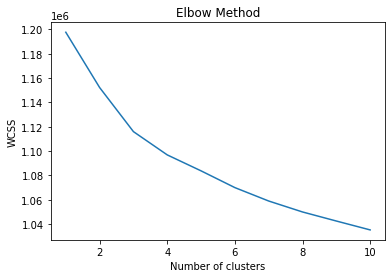

In [81]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X=w2v_model.wv.vectors.astype('double'))
    # inertia_ is sum of squared distance of samples to its closest cluster centers.
    wcss.append(kmeans.inertia_)
    print("inertia_", kmeans.inertia_)
    # print("wcss", within_css(kmeans))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [82]:
from sklearn.metrics import silhouette_score

def kmeansSilhouette(X,range_clusters):
    for i, k in range_clusters :

        # Run the Kmeans algorithm
        km = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)

        km.fit(X)
        labels = km.predict(X)

        print("For n_clusters =", k,
                  "The computed average silhouette_score is :", silhouette_score(X, labels, metric='euclidean'))

In [83]:
rangeClusters = enumerate([2,3,4,5,6,7,8,9,10])
kmeansSilhouette(w2v_model.wv.vectors.astype('double'), rangeClusters)

For n_clusters = 2 The average silhouette_score is : 0.03479409221940732
For n_clusters = 2 The computed average silhouette_score is : 0.03479409221940732
For n_clusters = 3 The average silhouette_score is : 0.047063074908886775
For n_clusters = 3 The computed average silhouette_score is : 0.047063074908886775
For n_clusters = 4 The average silhouette_score is : 0.04043813342738252
For n_clusters = 4 The computed average silhouette_score is : 0.04043813342738252
For n_clusters = 5 The average silhouette_score is : 0.03143777433864057
For n_clusters = 5 The computed average silhouette_score is : 0.03143777433864057
For n_clusters = 6 The average silhouette_score is : -0.008080516134488357
For n_clusters = 6 The computed average silhouette_score is : -0.008080516134488357
For n_clusters = 7 The average silhouette_score is : -0.015573730364179186
For n_clusters = 7 The computed average silhouette_score is : -0.015573730364179186
For n_clusters = 8 The average silhouette_score is : -0.0130

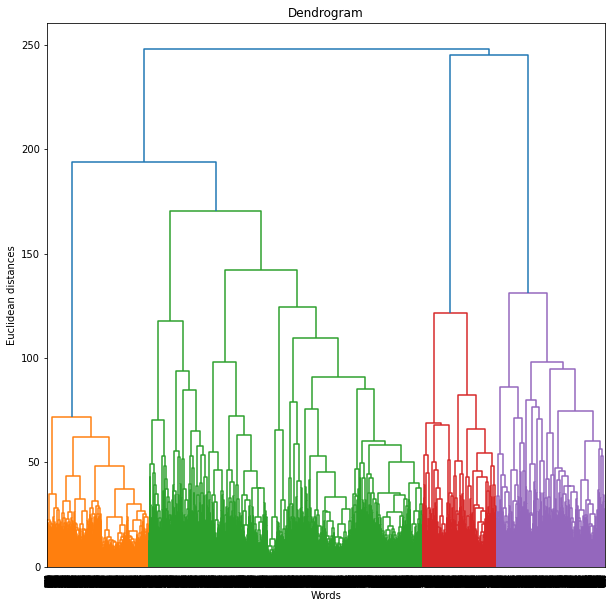

In [86]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(w2v_model.wv.vectors.astype('double'), method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Words')
plt.ylabel('Euclidean distances')
plt.show()

In [101]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
y_hc = hc.fit_predict(w2v_model.wv.vectors.astype('double'))

In [117]:
dfWords2 = pd.DataFrame(data=[w2v_model.wv.key_to_index.keys(), y_hc]).T
dfWords2.columns = ['words', 'clusters']
dfWords2['vectors'] = dfWords2.words.apply(lambda x: w2v_model.wv[f'{x}'])
dfWords2.head()

,words,clusters,vectors
0,be,0,"[-0.0927477, -0.14208923, 0.058706816, -0.2560..."
1,and,0,"[-0.28698897, -0.26512343, 0.25663704, -0.1716..."
2,the,1,"[-0.13803813, -0.18952447, 0.4213321, 0.163406..."
3,to,2,"[0.052224956, -0.124095224, 0.4544998, 0.01550..."
4,in,1,"[0.31688312, 0.39756396, -0.04785121, -0.26668..."


In [116]:
batch_nrs = len(w2v_model.wv.key_to_index.keys()) // 500
batch_nrs

17

In [122]:
silhouette_scores = []

for i in range(batch_nrs):
    silhouetteScore = silhouette_score(w2v_model.wv.vectors[i*500:(i+1)*500],
                                       y_hc[i*500:(i+1)*500],
                                       metric='euclidean')
    print(silhouetteScore)
    silhouette_scores.append(silhouetteScore)

finalSilhouetteScore = np.mean(silhouette_scores)
finalSilhouetteScore


0.023734545
-0.020631375
-0.0070487806
0.0037613302
0.014120397
0.009044545
0.010323811
0.0071021286
0.003086017
0.013017715
0.0017780903
-0.008456902
-0.007854482
-0.009499589
-0.01292545
-0.021994816
-0.017167289


-0.0011535354